In [1]:
%pylab inline
import numpy as np
from numpy.polynomial.polynomial import Polynomial
from numpy.polynomial.legendre import *

Populating the interactive namespace from numpy and matplotlib


# Intro to FEM

Finite Elements Method is the 'Art' of projecting an operator in the most suitable function space. 

### Projection: from Plane Geometry to Functional Analysis

Projecting a two dimentional vector $\mathbf{u} = (u_x, u_y)$ on the canonical basis $\{\mathbf{e}_x = (1,0), \mathbf{e}_y = (0,1)\}$, roughly speacking the $x$ and $y$ axes, is a weel known operation:

$$
\mathbf{u} = u_x \cdot \mathbf{e}_x + u_y \cdot \mathbf{e}_y.
$$

IWe can think of $u$ as a function defined on a domain $\Omega$ (and not a vector anymore). Then the $+$ sign is substituted by the integral over all the domain $\int_\Omega$. 

The canonical basis $\{\mathbf{e}_x, \mathbf{e}_y\}$ is substituted by another set $V$ wich is very similar to our canonincal basis, but has the very convenient chracteristic of being infinite, ancd composed of functions, not vectors:

$$
V = \{v_0, v_1, v_2, ..., v_\infty\}
$$

Now let's gradually move form the geometrical progection to the functional analysis projection. In plain geometry we sum all the $\mathbf{u}$ coponents, multiplied for all the basis vectors defining my space:


$$
u_x \cdot \mathbf{e}_x + u_y \cdot \mathbf{e}_y.
$$

Now we need only to substitute the word 'sum', with the $\int_\Omega$, and matically write 'for all the basis functions in the space that I choose' ($\forall v \in V$). We obtain the expression:

$$
\int_\Omega u\cdot v \quad \forall v \in V
$$

That's it. There are a lot theorems and elegant mathemathis in between these two expressions, but the ground foundations are not more complicated than this.

## Computational Mechanics

A simple mathematical tool like 'projection' can be effectively applied to computational mechanics. Mechanical phenomenca can be described by partial differential equations, and the resulting expressions can be very nasty. Let's bring up a couple of examples, called **strong formulations**.

- Heat Equation, $u$ is the temperature $f$ is the heat source

$$
\Delta u = \partial_{xx} u + \partial_{yy} u= f 
$$

- Linear Elasticity $\mathbf{u}$ is the displacement, $\mathbf{F}$ are the external forces.

$$
\nabla \cdot \left(C:\left(\frac{1}{2}\left(\nabla \mathbf{u}+\nabla \mathbf{u}^T\right)\right)\right) = \mathbf{F}
$$

It is clear that these operats look and, most of the times, are nasty. It is thanks to Galerkin's (and many otherthers') intuition that sounded a good idea to _project_ *operators*, onto *functions spaces*. In this way we can have a more *flexible* expression, called **weak formulation**:

- Heat Equation

$$
\Delta u = f \rightarrow \quad \int_\Omega \Delta u\cdot v = \int_\Omega f\cdot v \rightarrow \quad  \int_\Omega \nabla u\cdot \nabla v = \int_\Omega f\cdot v\quad  \forall v \in V
$$

- Linear Elasticity

$$
\mu \int_\Omega\mathbf{D}\mathbf{u}:\mathbf{D}\mathbf{v} + 
\lambda \int_\Omega\nabla\cdot\mathbf{u}\, \nabla\cdot\mathbf{v} =
\int_\Omega \mathbf{F}\quad \forall v \in V
$$

These formulations are more flexible for severa reasons:

 - Numerical quadrature makes easy to evaluate integral inside computers, rather then approximating derivatives as we do with the finite differences. With quadrature rule we sum small things rather than subtract, and we avoid cancellation errors for example.
 
 - We have the freedom (and responsability) to choose our base space, in order to better approximate the phenomenon we want to study.
 
 - It is not macroscopical, but week formulations are charcterized by first derivatives, that can be numerically approximated in a much better way.
 

## Point Cloud Approximation

The idea is simple, if projecting is good for nasty forces and nasty operators, wouldn't it be good to project point clouds on plain surfaces? 

Mathematically we look for the best approximation $u$ of the point cloud $f$. In strong form this simply the identity operator:
$$
u = f
$$

And in weak form, this is very simple:

$$
\int_\Omega u\cdot v = \int_\Omega f\cdot v, \quad \forall v\in V.
$$

With the last formula we have introduced three players:

 - $f$ is the function that represents the point cloud. $f$ is such that $\mathbb R^2 \rightarrow \mathbb{R}$, meaning that associates to each couple $(x,y)$ the coordinate $z$. We need to find a siutable way to represent this function. This cound be the a collection dirac deltas centered at each couple $(x,y)$, or a collection of gaussians centered at $(x,y)$, both scaled with the corresponding value of $z$. Several other speculations can be done to reconstruct this function, for example a delauny triangulation, but for now let's stick with these two options.
 
 - $v$ is the space on wich we want to project our cloud point. It defines the predetermined shape of the final space. Do we want to represent our point cloud as collection of linear functions? or quadratic? or bezier functions? or constants? There is a pletora of classical choices here.
 
 - $u$ is the collection of coefficients that we want to associate to each single basis function, and they are the unknows of our problem.:
$$
u = u^0 \cdot v_0 + u^1 \cdot v_1 + \ldots + u^\infty \cdot v_\infty = \sum_{i=0}^\infty u^i\cdot v_i
$$

Bottomline, we need to find the cofficents of predetermined shape functions that best approximate a point cloud.



## Reference Element

We need to define our space $V$. The first step is to introduce a reference element defined over the interval $(0,1)$. We define the `degree` of our `degree+1` basis functions. The $i$-th basis function is $1$ on the $i$-th degree of freedom, and $0$ on the others.

In [6]:
degree = 2
dofs = np.linspace(0,1,degree+1)
print dofs

[ 0.   0.5  1. ]


```
element     |-----|
1st degree  o-----o
2nd degree  o--o--o
3rd degree  o-o-o-o
```

In [7]:
V = [Polynomial.fromroots([xj for xj in dofs if xj != dofs[i]]) for i in range(degree+1)]
V = [V[i]/V[i](dofs[i]) for i in range(degree+1)]

### Representation of the basis functions on the reference element:

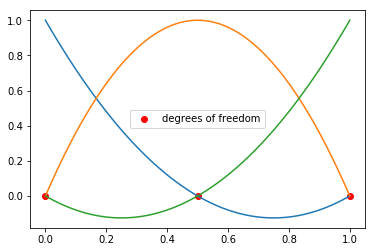

In [8]:
xi = linspace(0,1,1025)
plot(dofs, 0*dofs, 'ro', label='degrees of freedom')
legend()
for f in V:
    plot(xi, f(xi))


## Domain Discretization

In one dimension $\Omega = [0,L]$. We discretize the domain in `n` elements of amplitude $\Delta x$. In the finite elements literature the discretized domain is called `triangulation` or *Mesh*.

In [9]:
L = 1.
n = 2.**5
delta_x = L/n
triangulation = np.linspace(0,L,n+1)

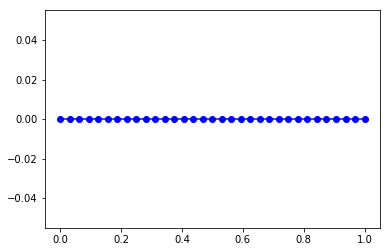

In [10]:
plot(triangulation, 0*triangulation, '-bo', label='triangulation')

## The complete set of basis functions

$v = v(\xi), \quad \xi\in[0,l]$

change of variables for the $i$-th interval:

$$
x = i\cdot \Delta x + \xi \cdot \Delta x
$$

$$
\xi = \frac{x}{\Delta x} - \Delta x \cdot i
$$


In [11]:
def push_forward(i,delta_x):
    return lambda xi : i*delta_x + xi*delta_x

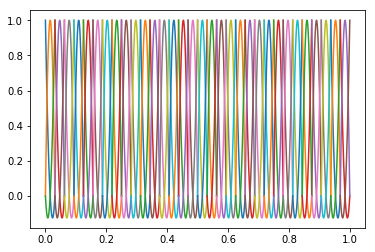

In [12]:
for i in range(int(n)):
    lm = push_forward(i,delta_x)
    x = lm(xi)
    for f in V:
        plot(x, f(xi))    

## Solving for the Unknowns

In [13]:
n_quad = degree+2
p,w = leggauss(n_quad)
w = .5 * w*delta_x
p = .5*(p+1)

W = diag(w)

B = np.zeros((int(degree+1),int(n_quad)))

for i in range(int(degree+1)):
    B[i,:] = V[i](p)

print B
local_matrix = B.dot(W.dot(B.T))
print local_matrix

[[ 0.80134603  0.22778408 -0.11219697 -0.05979028]
 [ 0.25844425  0.88441289  0.88441289  0.25844425]
 [-0.05979028 -0.11219697  0.22778408  0.80134603]]
[[ 0.00416667  0.00208333 -0.00104167]
 [ 0.00208333  0.01666667  0.00208333]
 [-0.00104167  0.00208333  0.00416667]]


In [14]:
def get_gaussian(p,sigma):
    return lambda x : np.exp(-(x-p)**2/(2*sigma**2))

In [15]:
def get_pull_back(i,delta_x):
    return lambda x : (x-i*delta_x)/delta_x 

In [16]:
A = np.zeros((int(degree*n+1),int(degree*n+1)))
print A.shape

f = np.zeros((int(degree*n+1),))

#force = lambda x : np.sin(2*np.pi*x/L)
force = get_gaussian(np.pi/2,.1)

for i in range(int(n)):
    local_dofs = np.arange(int(degree*i),int(degree*(i+1)+1))
    A[np.ix_(local_dofs,local_dofs)] += local_matrix
    lm = push_forward(i,delta_x)
    x_quad = lm(p)
    f[local_dofs]+=B.dot(W.dot(force(x_quad)))
#spy(A)
u = np.linalg.solve(A, f)
#print u

(65, 65)


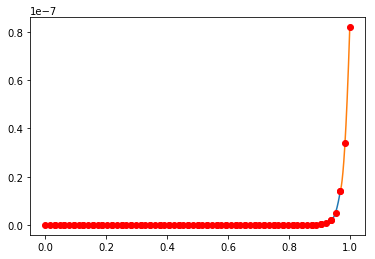

In [17]:
for i in range(int(n)):
    lm = push_forward(i,delta_x)
    local_dofs = np.arange(int(degree*i),int(degree*(i+1)+1))
    x = lm(xi)
    sol = np.zeros(x.shape)
    for i in range(degree+1):
        sol+=u[local_dofs[i]]*V[i](xi)
    plot(x, sol)

for i in range(int(n)):
    local_dofs = np.arange(int(degree*i),int(degree*(i+1)+1))
    lm = push_forward(i,delta_x)
    
    plot(lm(dofs), u[local_dofs],'or')

In [18]:
#points = [np.pi/2.]

print triangulation
print delta_x

points = [triangulation[triangulation.shape[0]/3]]

print points


f = np.zeros((int(degree*n+1),))

for p in points:
    el_id = np.floor(p/delta_x)
    local_dofs = np.arange(int(degree*el_id),int(degree*(el_id+1)+1))
    print "el_id = ", el_id
    #print p
    pb = get_pull_back(el_id,delta_x)
    xi = pb(p)
    print "p = ", p
    print "xi = ", xi
    phi_val = np.zeros((degree+1,))
    for i in range(degree+1):
        phi_val[i] = V[i](xi)
    print phi_val
    f[local_dofs]+= phi_val

u = np.linalg.solve(A, f)
print u

[ 0.       0.03125  0.0625   0.09375  0.125    0.15625  0.1875   0.21875
  0.25     0.28125  0.3125   0.34375  0.375    0.40625  0.4375   0.46875
  0.5      0.53125  0.5625   0.59375  0.625    0.65625  0.6875   0.71875
  0.75     0.78125  0.8125   0.84375  0.875    0.90625  0.9375   0.96875
  1.     ]
0.03125
[0.34375]
el_id =  11.0
p =  0.34375
xi =  0.0
[ 1.  0.  0.]
[  1.02979588e-06  -5.14897939e-07   3.08938763e-06  -2.57448969e-06
   1.75065299e-05  -1.49320402e-05   1.01949792e-04  -8.70177517e-05
   5.94192222e-04  -5.07174470e-04   3.46320354e-03  -2.95602907e-03
   2.01850290e-02  -1.72289999e-02   1.17646970e-01  -1.00417971e-01
   6.85696794e-01  -5.85278823e-01   3.99653379e+00  -3.41125497e+00
   2.32935060e+01  -1.98822510e+01   1.35764502e+02  -1.98822510e+01
   2.32935060e+01  -3.41125497e+00   3.99653379e+00  -5.85278823e-01
   6.85696794e-01  -1.00417971e-01   1.17646970e-01  -1.72289999e-02
   2.01850290e-02  -2.95602906e-03   3.46320346e-03  -5.07174405e-04
   5.94

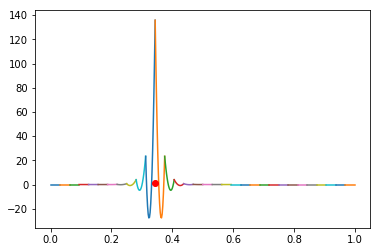

In [19]:
xi = np.linspace(0,1,2**4)
for i in range(int(n)):
    lm = push_forward(i,delta_x)
    local_dofs = np.arange(int(degree*i),int(degree*(i+1)+1))
    x = lm(xi)
    sol = np.zeros(x.shape)
    for i in range(degree+1):
        sol+=u[local_dofs[i]]*V[i](xi)
    plot(x,sol)

for p in points:
    plot(p,1,'or')